1. Lets do the evaluation for each of these quarters individually, store the result in a list and tehn calculate the standard deviation.  - done
2. lets make it modular so that we can just specify the algorithm as a string, and then use the appropiate algorithm - can't use trended rn :(
3. add phase folded diagrams on this  
4. lets also put this all in a function, so we can just specify the data folder. Then lets create modified time series to simulate ground observation and then run the above code on that as well and report results - TODO

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.timeseries import LombScargle
from pathlib import Path
from lightkurve import KeplerLightCurveFile
import math
from gatspy.periodic import *

In [109]:
pwd

'C:\\Users\\tulik\\OneDrive\\Desktop\\roto-project'

In [110]:
path_to_files = "C:/Users/tulik/OneDrive/Desktop/roto-project/MAST_2025-10-23T2232/MAST_2025-10-23T2232/Kepler/kplr005110407_lc_Q001111011101110111/kplr005110407_lc_Q001111011101110111_all_files/005110407"

In [111]:
folder = Path(path_to_files)

# find all .fits files in the folder (non-recursive)
fits_files = list(folder.glob("*.fits"))

In [112]:
light_curves= []
for file in fits_files:
    lcfile = KeplerLightCurveFile(file)
    lc = lcfile.PDCSAP_FLUX.remove_nans()
    light_curves.append(lcfile)

C:\Users\tulik\AppData\Local\Temp\ipykernel_40896\938730691.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcfile.PDCSAP_FLUX.remove_nans()
C:\Users\tulik\AppData\Local\Temp\ipykernel_40896\938730691.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcfile.PDCSAP_FLUX.remove_nans()
C:\Users\tulik\AppData\Local\Temp\ipykernel_40896\938730691.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcfile.PDCSAP_FLUX.remove_nans()
C:\Users\tulik\AppData\Local\Temp\ipykernel_40896\938730691.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcfile.PDCSAP_FLUX.remove_nans()
C:\Users\tulik\AppData\Local\Temp\ipykernel_40896\938730691.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and m

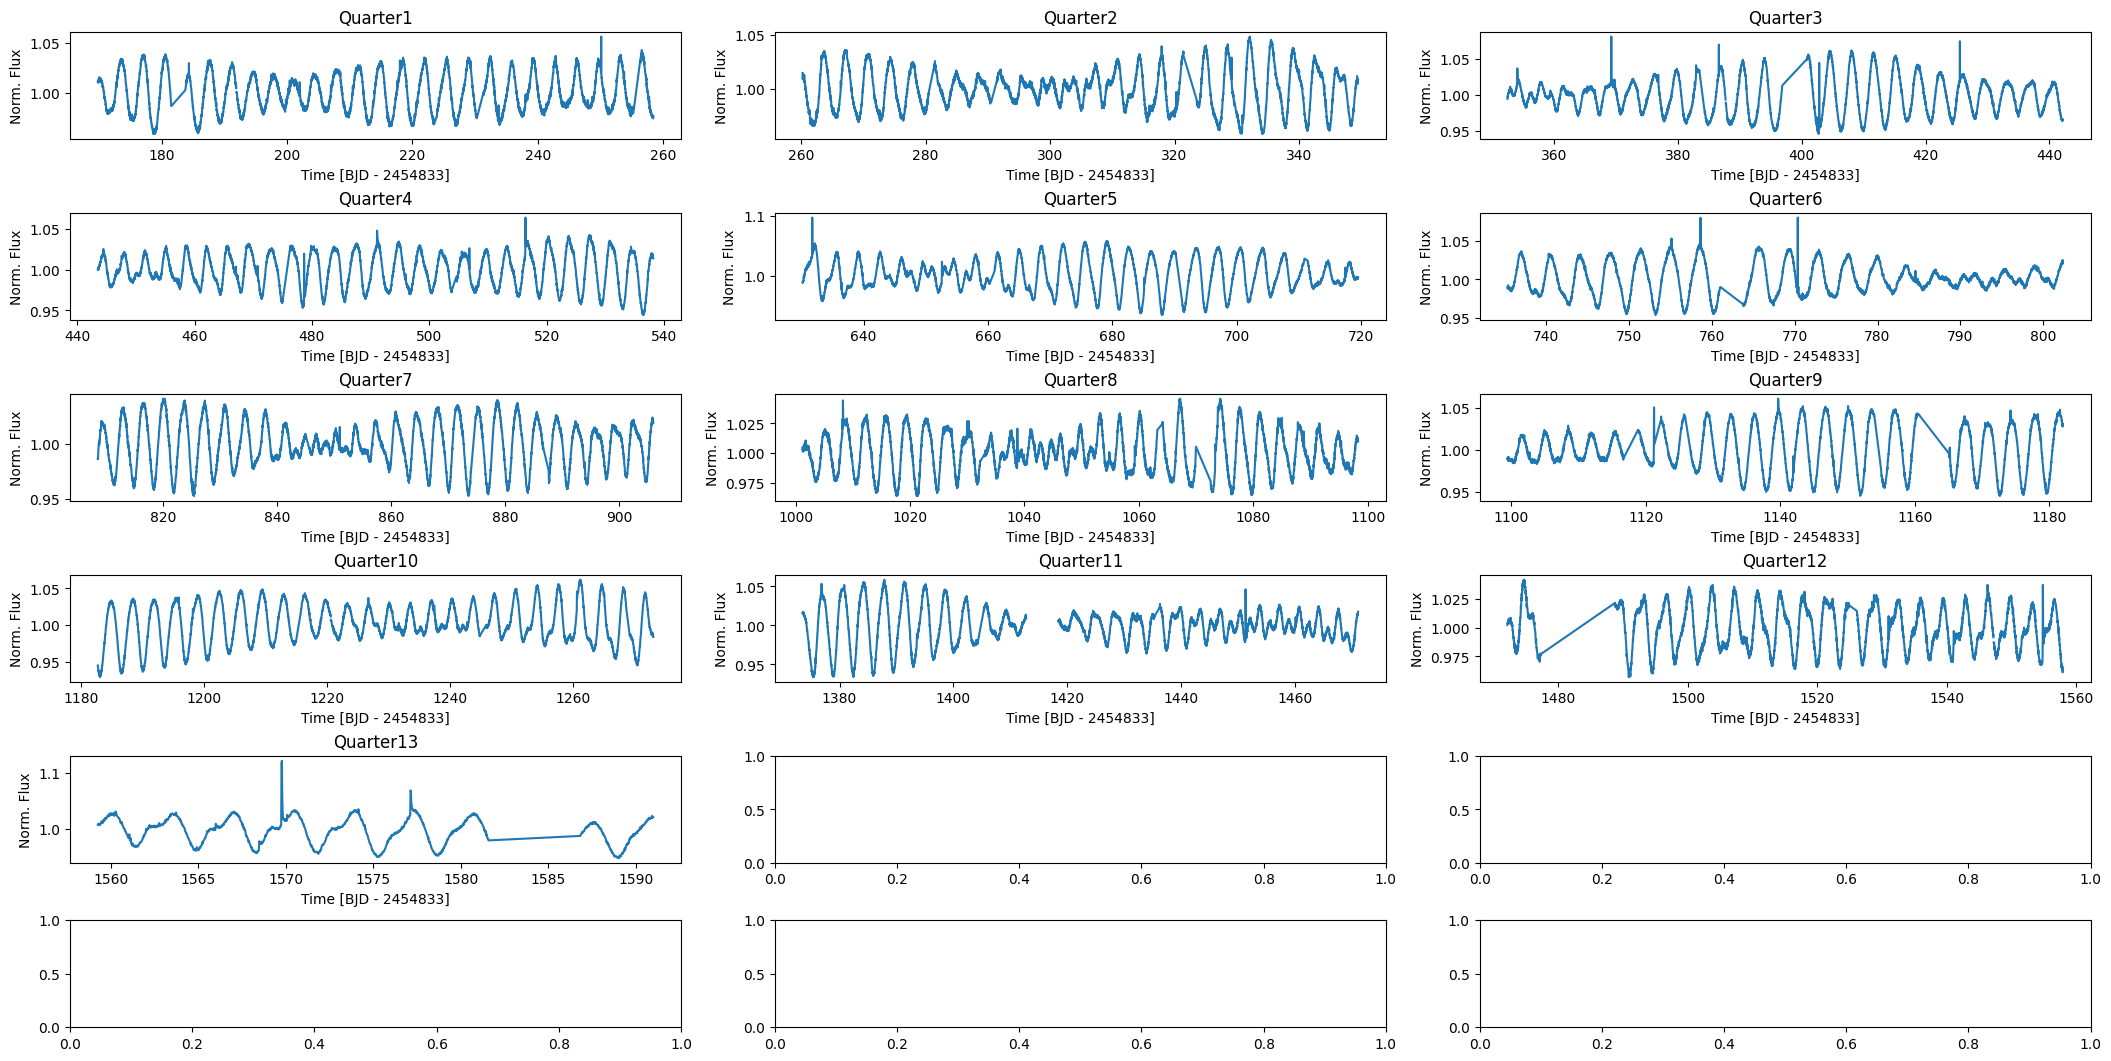

In [169]:
cols = 6
rows = math.ceil(len(light_curves) / cols)

# Create figure
fig, axes = plt.subplots(cols, rows, figsize=(3.5 * cols, 3.5 * rows), layout="constrained")
axes = axes.flatten()  # flatten grid to simple list

# Loop over files and axes
for i,(lc, ax) in enumerate(zip(light_curves, axes)):
    # Normalize
    flux = lc.flux.value / np.nanmedian(lc.flux.value)
    time = lc.time.value
    # Plot each quarter
    ax.plot(time, flux) # shows quarter start time
    ax.set_title("Quarter" + str(i+1))
    ax.set_xlabel("Time [BJD - 2454833]")
    ax.set_ylabel("Norm. Flux")
    
plt.show()

In [193]:
def process_light_curves(light_curves, algorithm):
    best_periods = []
    for (i, lc) in enumerate(light_curves):
        time = lc.time.value
        flux = lc.flux.value
        mask = np.isfinite(time) & np.isfinite(flux)
        time = np.asarray(time[mask])
        flux = np.asarray(flux[mask])
        flux = (flux / np.nanmedian(flux)) - 1
    
        # Instantiate model
        match(algorithm):
            case "general":
               model = LombScargle()
            case "fast":
                model = LombScargleFast()
            case "trended":
                model =  TrendedLombScargle()
        model.fit(time,flux)
        # Define period/frequency grid
        periods = np.linspace(0.1, 100, 10000)  # days
        power = model.score(periods)
        
        # Find best period
        best_period = periods[np.argmax(power)]
        best_periods.append(best_period)

        if i == 0:
            # Plot periodogram
            plt.figure(figsize=(8,4))
            plt.plot(periods, power)
            plt.xlabel("Period [days]")
            plt.ylabel("Lomb–Scargle Power")
            plt.title("Lomb–Scargle Periodogram " + algorithm)
            plt.xscale("log")
            plt.show()
            print("best period is " + str(best_period) + " days")
    return best_periods

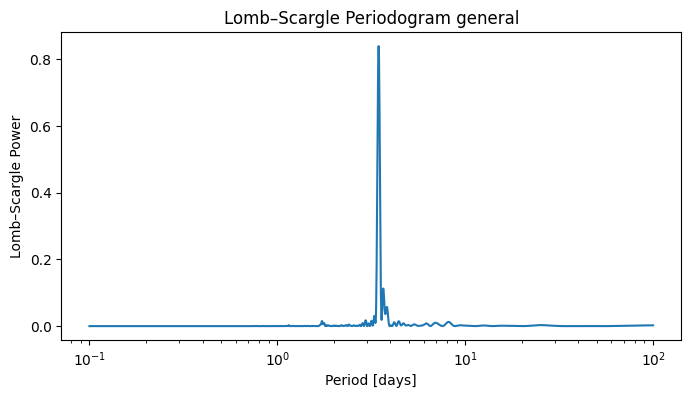

best period is 3.4569756975697574 days


In [194]:
general_best_periods = process_light_curves(light_curves, "general")

C:\Users\tulik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\gatspy\periodic\lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


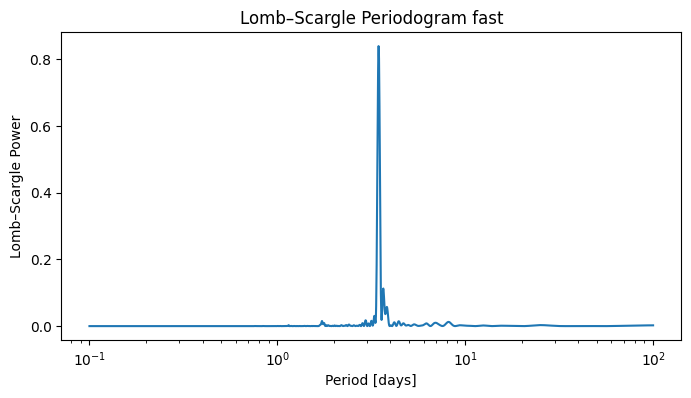

best period is 3.4569756975697574 days


In [195]:
fast_best_periods = process_light_curves(light_curves, "fast")

In [196]:
def print_result(best_periods):
    print("result of lomb scargle period calculation (general) is " +  str(np.mean(best_periods)) + " ± " + str(np.std(best_periods)) + " days") 

In [197]:
print_result(general_best_periods)

result of lomb scargle period calculation (general) is 3.5322924600152326 ± 0.07833815542871944 days


In [198]:
print_result(fast_best_periods)

result of lomb scargle period calculation (general) is 3.5322924600152326 ± 0.07833815542871944 days


This all works so far. lets try to do phase folded curves for the two lomb scargle things //TODO